In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/SCDC/testSI(S)`


In [2]:
using Graphs
using JLD2, CSV, DataFrames, NPZ
using StatsBase
using SmallCouplingDynamicCavity
using PyCall
using Random
import PyPlot as plt
using Statistics
using LaTeXStrings

In [3]:
# Define the saving structure, in which the results will be saved
struct SaveStruct
    s::Int
    ε_autoinf::Float64
    maxiter::Union{Int,Array{Int}}
    damp::Union{Float64,Array{Float64}}
    μ_cutoff::Float64
    fpn::Float64
    n_iter_nc::Int
    damp_nc::Float64
    AUC::Float64
    converged::Bool

    SaveStruct(s) = new(s, 0.0, 0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, false)
    SaveStruct(s, ε_autoinf, maxiter, damp, μ_cutoff, fpn, n_iter_nc, damp_nc, auc, converged) = new(s, ε_autoinf, maxiter, damp, μ_cutoff, fpn, n_iter_nc, damp_nc, auc, converged)
end

to_rgba(col, alpha) = plt.matplotlib.colors.to_rgba(col, alpha)

function plot_ribbon!(ax, x, y, yerr; lab="", mark="o", col="C0", ls="--", lw=1, mew=.5, ms=5, zorder=0)
    lower = y .- yerr
    upper = y .+ yerr

    # Plot with error bars
    line = ax.plot(x, y, label=lab, marker=mark, color=to_rgba(col, .5), linestyle=ls, linewidth=lw, markerfacecolor=to_rgba(col, 1), markeredgecolor=to_rgba("dimgray", 1), markeredgewidth=mew, markersize=ms, zorder=zorder)
    
    # Add ribbon
    ax.fill_between(x, lower, upper, facecolor=to_rgba(col, .2), edgecolor=to_rgba(col, 0), zorder=zorder)
    
    return line
end

plot_ribbon! (generic function with 1 method)

# Varying lambda   

## Proximity random graphs

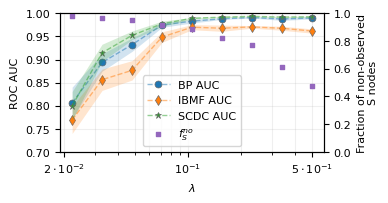

In [42]:
n_sample = 50
sims = collect(1:n_sample)

# Parameters
T = 15
NV = 300
lmax = sqrt(1.8/NV)
n_sr = 2
γ = n_sr/NV
λs = 10 .^ (collect(range(log10(0.015), log10(0.5), length=10)))[2:end]
n_obs = floor(Int, .3*NV)
n_unobs = NV-n_obs

fig, ax1 = plt.subplots(figsize=(3.4,1.8))
ax2 = ax1.twinx()
rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 8  #9 18

############## SIB & IBMF ########################
sib = CSV.read("logs/test_SI/var_lambda/accu_sib_all_lambdas.csv", DataFrame)
ibmf = CSV.read("logs/test_SI/var_lambda/accu_MF_all_lambdas.csv", DataFrame)

SIB_aucs_m = zeros(length(λs))
SIB_aucs_err = zeros(length(λs))
SIB_converged = zeros(length(λs))
IBMF_aucs_m = zeros(length(λs))
IBMF_aucs_err = zeros(length(λs))

for (idx, λ₀) in enumerate(λs)
    λ₀ = round(λ₀, digits=4)
    
    SIB_aucs = sib[in([λ₀]).(sib.lamb),"auc"]
    IBMF_aucs = ibmf[in([λ₀]).(ibmf.lamb),"auc"]
    SIB_conv = sib[in([λ₀]).(sib.lamb),"sib_conv"]
    
    filter!(x->typeof(x) != Missing, SIB_aucs)
    filter!(x->typeof(x) != Missing, IBMF_aucs)
    
    SIB_aucs_m[idx] = mean(SIB_aucs)
    SIB_aucs_err[idx] = sem(SIB_aucs, mean=SIB_aucs_m[idx])
    SIB_converged[idx] = mean(SIB_conv)
    IBMF_aucs_m[idx] = mean(IBMF_aucs)
    IBMF_aucs_err[idx] = sem(IBMF_aucs, mean=IBMF_aucs_m[idx])
end
##################################################


############### SCDC #############################
SCDC_aucs_m = zeros(length(λs))
SCDC_aucs_err = zeros(length(λs))
SCDC_converged = zeros(length(λs))

lamb = zeros(length(λs)*n_sample)
seed = zeros(Int, length(λs)*n_sample)
n_unobs = zeros(Int, length(λs)*n_sample)
n_pos = zeros(Int, length(λs)*n_sample)
auc = zeros(length(λs)*n_sample)
scdc_conv = Vector{Bool}(undef, length(λs)*n_sample)

for (idx, λ₀) in enumerate(λs)
    λ₀ = round(λ₀, digits=4)
    save_vec = JLD2.load_object("logs/test_SI/var_lambda/lam_$(λ₀)/optim_pars_rand_geom.jld2")
    SCDC_aucs = [save_struct.AUC for save_struct in save_vec]
    SCDC_conv =[save_struct.converged for save_struct in save_vec]
    
    lamb[(idx-1)*n_sample+1:idx*n_sample] .= λ₀
    seed[(idx-1)*n_sample+1:idx*n_sample] .= [save_struct.s for save_struct in save_vec]
    auc[(idx-1)*n_sample+1:idx*n_sample] .= SCDC_aucs
    scdc_conv[(idx-1)*n_sample+1:idx*n_sample] .= SCDC_conv
    
    filter!(x->x ≠ 0.0, SCDC_aucs)
    
    SCDC_aucs_m[idx] = mean(SCDC_aucs)
    SCDC_aucs_err[idx] = sem(SCDC_aucs, mean=SCDC_aucs_m[idx])
    SCDC_converged[idx] = mean(SCDC_conv)
end
##################################################


################## Plot AUCS  ####################
line_SIB = plot_ribbon!(ax1, λs, SIB_aucs_m, SIB_aucs_err; lab="BP AUC", mark="o", col="C0", zorder=20)
line_IBMF = plot_ribbon!(ax1, λs, IBMF_aucs_m, IBMF_aucs_err; lab="IBMF AUC", mark="d", col="C1", zorder=30)
line_SCDC = plot_ribbon!(ax1, λs, SCDC_aucs_m, SCDC_aucs_err; lab="SCDC AUC", mark="*", col="C2", zorder=40)
####################################################

############### Plot avg_S  ########################
avg_S_unobs = zeros(length(λs))

for (idx,λ₀) in enumerate(λs)
    λ₀ = round(λ₀, digits=4)
    avg_S = 0.0
    for s in sims
        # Load the data
        path = "data/test_SI/var_lambda/data_rand_geom/lam_$(λ₀)/N-$(NV)_lmax-$(lmax)_tlim-$(T)_nsrc-$(n_sr)_lam-$(λ₀)_nobs-$(n_obs)_s-$(s)"
        confs = npzread(path*"_confs.npy")
        obs_df = CSV.read(path*"_obs_sparse.csv", DataFrame)
        obs_df.node .+= 1
        obs_df.time .+= 1

        # define unobserved nodes
        unobs_nodes = Vector(1:NV)
        filter!(e->!(e in obs_df.node), unobs_nodes)
        n_unobs[(idx-1)*s+1] = length(unobs_nodes)
        confs_unobs = Int8.(confs[1,2,unobs_nodes])
        
        n_pos[(idx-1)*s+1] = sum(confs_unobs)
        avg_S += 1 - sum(confs_unobs)/(length(unobs_nodes))
    end
    avg_S_unobs[idx] = avg_S/n_sample
end

pts_S = ax2.scatter(λs, avg_S_unobs, label=L"f_S^{no}", color="C4", s=5, marker="s") 
ax2.set_ylabel("Fraction of non-observed\nS nodes")
ax2.set_ylim(0,1)
##############################################

lns1, labs1 = ax1.get_legend_handles_labels() 
lns2, labs2 = ax2.get_legend_handles_labels() 
ax1.legend(vcat(lns1, lns2), vcat(labs1, labs2), loc="lower center")
ax1.grid(alpha=.2, which="both")
ax1.set_ylim(0.7,1)
ax1.set_yticks(0.7:.05:1)
ax1.set_xlabel(L"$\lambda$")
ax1.set_ylabel("ROC AUC")
ax1.set_xscale("log")
ax2.set_zorder(ax1.get_zorder()+1)
ax1.patch.set_visible(false)
ax1.set_xticks([0.02, 0.1, 0.5])
ax1.set_xticklabels([L"$2\cdot 10^{-2}$", L"$10^{-1}$", L"$5\cdot 10^{-1}$"])

fig.savefig("AUC_var_lambda_ribbon.pdf", bbox_inches="tight")

df = DataFrame(lamb=lamb, seed=seed, n_unobs=n_unobs, n_pos=n_pos, auc=auc, scdc_conv=scdc_conv);
CSV.write("logs/test_SI/var_lambda/accu_scdc_all_lambdas.csv", df)

Fraction of converged instancies:
λs  : [0.0221, 0.0326, 0.0482, 0.0712, 0.1052, 0.1553, 0.2293, 0.3386, 0.5]
BP  : [1.0, 0.98, 1.0, 0.68, 0.48, 0.2, 0.12, 0.06, 0.0]
SCDC: [0.7, 0.5, 0.48, 0.2, 0.16, 0.16, 0.16, 0.08, 0.06]


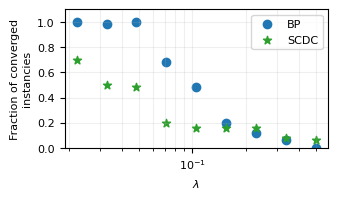

(0.0, 1.1)

In [43]:
println("Fraction of converged instancies:")
println("λs  : $(floor.(λs,digits=4))")
println("BP  : $(floor.(SIB_converged,digits=4))")
println("SCDC: $(floor.(SCDC_converged,digits=4))")

fig,ax = plt.subplots(figsize=(3.4,1.8))
ax.scatter(λs, SIB_converged, label="BP", c="C0", marker="o")
ax.scatter(λs, SCDC_converged, label="SCDC", c="C2", marker="*")
ax.legend()
ax.set_xlabel(L"$\lambda$")
ax.set_ylabel("Fraction of converged\ninstancies")
ax.set_xscale("log")
ax.grid(alpha=.2, which="both")
ax.set_ylim(0,1.1)

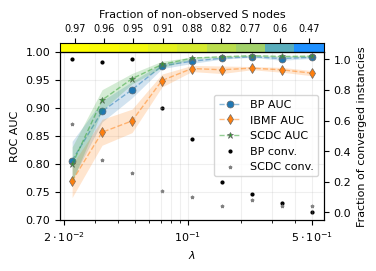

In [103]:
n_sample = 50
sims = collect(1:n_sample)

# Parameters
T = 15
NV = 300
lmax = sqrt(1.8/NV)
n_sr = 2
γ = n_sr/NV
λs = 10 .^ (collect(range(log10(0.015), log10(0.5), length=10)))[2:end]
n_obs = floor(Int, .3*NV)
n_unobs = NV-nobs

fig, axis = plt.subplots(2, 1, figsize=(3.4,2.3), height_ratios=(.05,.95))
ax1 = axis[2,1]
ax3 = axis[1,1]
ax2 = ax1.twinx()
rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 8  #9 18

############## SIB & IBMF ########################
sib = CSV.read("logs/test_SI/var_lambda/accu_sib_all_lambdas.csv", DataFrame)
ibmf = CSV.read("logs/test_SI/var_lambda/accu_MF_all_lambdas.csv", DataFrame)

SIB_aucs_m = zeros(length(λs))
SIB_aucs_err = zeros(length(λs))
SIB_converged = zeros(length(λs))
IBMF_aucs_m = zeros(length(λs))
IBMF_aucs_err = zeros(length(λs))

for (idx, λ₀) in enumerate(λs)
    λ₀ = round(λ₀, digits=4)
    
    SIB_aucs = sib[in([λ₀]).(sib.lamb),"auc"]
    IBMF_aucs = ibmf[in([λ₀]).(ibmf.lamb),"auc"]
    SIB_conv = sib[in([λ₀]).(sib.lamb),"sib_conv"]
    
    filter!(x->typeof(x) != Missing, SIB_aucs)
    filter!(x->typeof(x) != Missing, IBMF_aucs)
    
    SIB_aucs_m[idx] = mean(SIB_aucs)
    SIB_aucs_err[idx] = sem(SIB_aucs, mean=SIB_aucs_m[idx])
    SIB_converged[idx] = mean(SIB_conv)
    IBMF_aucs_m[idx] = mean(IBMF_aucs)
    IBMF_aucs_err[idx] = sem(IBMF_aucs, mean=IBMF_aucs_m[idx])
end
##################################################


############### SCDC #############################
SCDC_aucs_m = zeros(length(λs))
SCDC_aucs_err = zeros(length(λs))
SCDC_converged = zeros(length(λs))

lamb = zeros(length(λs)*n_sample)
seed = zeros(Int, length(λs)*n_sample)
n_unobs = zeros(Int, length(λs)*n_sample)
n_pos = zeros(Int, length(λs)*n_sample)
auc = zeros(length(λs)*n_sample)
scdc_conv = Vector{Bool}(undef, length(λs)*n_sample)

for (idx, λ₀) in enumerate(λs)
    λ₀ = round(λ₀, digits=4)
    save_vec = JLD2.load_object("logs/test_SI/var_lambda/lam_$(λ₀)/optim_pars_rand_geom.jld2")
    SCDC_aucs = [save_struct.AUC for save_struct in save_vec]
    SCDC_conv =[save_struct.converged for save_struct in save_vec]
    
    lamb[(idx-1)*n_sample+1:idx*n_sample] .= λ₀
    seed[(idx-1)*n_sample+1:idx*n_sample] .= [save_struct.s for save_struct in save_vec]
    auc[(idx-1)*n_sample+1:idx*n_sample] .= SCDC_aucs
    scdc_conv[(idx-1)*n_sample+1:idx*n_sample] .= SCDC_conv
    
    filter!(x->x ≠ 0.0, SCDC_aucs)
    
    SCDC_aucs_m[idx] = mean(SCDC_aucs)
    SCDC_aucs_err[idx] = sem(SCDC_aucs, mean=SCDC_aucs_m[idx])
    SCDC_converged[idx] = mean(SCDC_conv)
end
##################################################


################## Plot AUCS  ####################
line_SIB = plot_ribbon!(ax1, λs, SIB_aucs_m, SIB_aucs_err; lab="BP AUC", mark="o", col="C0", zorder=20)
line_IBMF = plot_ribbon!(ax1, λs, IBMF_aucs_m, IBMF_aucs_err; lab="IBMF AUC", mark="d", col="C1", zorder=30)
line_SCDC = plot_ribbon!(ax1, λs, SCDC_aucs_m, SCDC_aucs_err; lab="SCDC AUC", mark="*", col="C2", zorder=40)
####################################################

############### Plot avg_S  ########################
avg_S_unobs = zeros(length(λs))

for (idx,λ₀) in enumerate(λs)
    λ₀ = round(λ₀, digits=4)
    avg_S = 0.0
    for s in sims
        # Load the data
        path = "data/test_SI/var_lambda/data_rand_geom/lam_$(λ₀)/N-$(NV)_lmax-$(lmax)_tlim-$(T)_nsrc-$(n_sr)_lam-$(λ₀)_nobs-$(n_obs)_s-$(s)"
        confs = npzread(path*"_confs.npy")
        obs_df = CSV.read(path*"_obs_sparse.csv", DataFrame)
        obs_df.node .+= 1
        obs_df.time .+= 1

        # define unobserved nodes
        unobs_nodes = Vector(1:NV)
        filter!(e->!(e in obs_df.node), unobs_nodes)
        n_unobs[(idx-1)*s+1] = length(unobs_nodes)
        confs_unobs = Int8.(confs[1,2,unobs_nodes])
        
        n_pos[(idx-1)*s+1] = sum(confs_unobs)
        avg_S += 1 - sum(confs_unobs)/(length(unobs_nodes))
    end
    avg_S_unobs[idx] = avg_S/n_sample
end

# Custom color gradient
color1 = "dodgerblue"  # Starting color
color2 = "yellow"      # Ending color
# Create a colormap using LinearSegmentedColormap
cm = plt.matplotlib.colors.LinearSegmentedColormap.from_list("custom_cmap", [color1, color2])

avg_S_unobs = reshape(avg_S_unobs, (1,length(λs)))
pts_S = ax3.pcolormesh(avg_S_unobs,  cmap=cm)
ax3.set_xticks(.5:1:8.5)
ax3.set_xticklabels(floor.(avg_S_unobs[1,:],digits=2))
ax3.tick_params(left=false, right=false, labelleft=false, labelbottom=false, bottom=false, top=true, labeltop=true, labelsize=7)
ax3.set_xlabel("Fraction of non-observed S nodes")
ax3.xaxis.set_label_position("top")
##############################################


############ Plot average convergence ########
ax2.scatter(λs, SIB_converged, color="black", label="BP conv.", marker="o", zorder=0, s=4)
ax2.scatter(λs, SCDC_converged, color="gray", label="SCDC conv.", marker="*", zorder=0, s=4)
ax2.set_ylabel("Fraction of converged instancies")
##############################################

lns1, labs1 = ax1.get_legend_handles_labels() 
lns2, labs2 = ax2.get_legend_handles_labels() 
ax1.legend(vcat(lns1, lns2), vcat(labs1, labs2), loc="center right")
ax1.grid(alpha=.2, which="both")
ax1.set_ylim(0.7,1)
ax1.set_yticks(0.7:.05:1)
ax1.set_xlabel(L"$\lambda$")
ax1.set_ylabel("ROC AUC")
ax1.set_xscale("log")
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(false)
ax1.set_xticks([0.02, 0.1, 0.5])
ax1.set_xticklabels([L"$2\cdot 10^{-2}$", L"$10^{-1}$", L"$5\cdot 10^{-1}$"])

plt.subplots_adjust(wspace=0, hspace=0)

#fig.savefig("AUC_var_lambda_ribbon.pdf", bbox_inches="tight")

df = DataFrame(lamb=lamb, seed=seed, n_unobs=n_unobs, n_pos=n_pos, auc=auc, scdc_conv=scdc_conv)
CSV.write("logs/test_SI/var_lambda/accu_scdc_all_lambdas.csv", df)

# Varying obs 

## Proximity random graphs

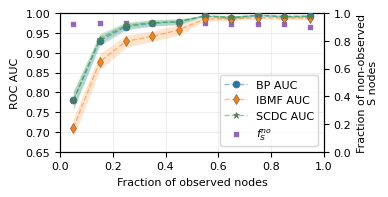

"logs/test_SI/var_lambda/accu_scdc_all_nobs.csv"

In [46]:
n_sample = 50
sims = collect(1:n_sample)

# Parameters
T = 15
NV = 300
lmax = round(sqrt(1.8/NV), digits=3)
n_sr = 2
γ = n_sr/NV
λ₀ = 0.07
fracs_obs = collect(range(.05, .95, length=10))

fig, ax1 = plt.subplots(figsize=(3.4,1.8))
ax2 = ax1.twinx()
rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 8  #9 18


############## SIB & IBMF ########################
sib = CSV.read("logs/test_SI/var_obs/accu_sib_all_nobs.csv", DataFrame)
ibmf = CSV.read("logs/test_SI/var_obs/accu_MF_all_nobs.csv", DataFrame)

SIB_aucs_m = zeros(length(fracs_obs))
SIB_aucs_err = zeros(length(fracs_obs))
SIB_converged = zeros(length(fracs_obs))
IBMF_aucs_m = zeros(length(fracs_obs))
IBMF_aucs_err = zeros(length(fracs_obs))

for (idx, frac_obs) in enumerate(fracs_obs)
    nobs = floor(Int, frac_obs*NV)
    
    SIB_aucs = sib[in([nobs]).(sib.nobs),"auc"]
    IBMF_aucs = ibmf[in([nobs]).(ibmf.nobs),"auc"]
    SIB_conv = sib[in([λ₀]).(sib.lamb),"sib_conv"]
    
    filter!(x->typeof(x) != Missing, SIB_aucs)
    filter!(x->typeof(x) != Missing, IBMF_aucs)
    
    SIB_aucs_m[idx] = mean(SIB_aucs)
    SIB_aucs_err[idx] = sem(SIB_aucs, mean=SIB_aucs_m[idx])
    SIB_converged[idx] = mean(SIB_conv)
    IBMF_aucs_m[idx] = mean(IBMF_aucs)
    IBMF_aucs_err[idx] = sem(IBMF_aucs, mean=IBMF_aucs_m[idx])
end
##################################################


############### SCDC #############################
SCDC_aucs_m = zeros(length(fracs_obs))
SCDC_aucs_err = zeros(length(fracs_obs))
SCDC_converged = zeros(length(fracs_obs))

lamb = zeros(length(fracs_obs)*n_sample)
seed = zeros(Int, length(fracs_obs)*n_sample)
n_obs = zeros(Int, length(fracs_obs)*n_sample) 
n_unobs = zeros(Int, length(fracs_obs)*n_sample)
n_pos = zeros(Int, length(fracs_obs)*n_sample)
auc = zeros(length(fracs_obs)*n_sample)
scdc_conv = Vector{Bool}(undef, length(fracs_obs)*n_sample)

for (idx, frac_obs) in enumerate(fracs_obs)
    nobs = floor(Int, frac_obs*NV)
    save_vec = JLD2.load_object("logs/test_SI/var_obs/data_rand_geom/N-$(NV)_lmax-$(lmax)_tlim-$(T)_nsrc-$(n_sr)_lamb-$(λ₀)/nobs_$(nobs)/optim_pars_rand_geom.jld2")
    SCDC_aucs = [save_struct.AUC for save_struct in save_vec]
    SCDC_conv = [save_struct.converged for save_struct in save_vec]
    
    lamb[(idx-1)*n_sample+1:idx*n_sample] .= λ₀
    seed[(idx-1)*n_sample+1:idx*n_sample] .= [save_struct.s for save_struct in save_vec]
    auc[(idx-1)*n_sample+1:idx*n_sample] .= SCDC_aucs
    scdc_conv[(idx-1)*n_sample+1:idx*n_sample] .= SCDC_conv
        
    filter!(x->x ≠ 0.0, SCDC_aucs)
    
    SCDC_aucs_m[idx] = mean(SCDC_aucs)
    SCDC_aucs_err[idx] = sem(SCDC_aucs, mean=SCDC_aucs_m[idx])
    SCDC_converged[idx] = mean(SCDC_conv)
end
##################################################



################## Plot AUCS  ####################
line_SIB = plot_ribbon!(ax1, fracs_obs, SIB_aucs_m, SIB_aucs_err; lab="BP AUC", mark="o", col="C0", zorder=20)
line_IBMF = plot_ribbon!(ax1, fracs_obs, IBMF_aucs_m, IBMF_aucs_err; lab="IBMF AUC", mark="d", col="C1", zorder=30)
line_SCDC = plot_ribbon!(ax1, fracs_obs, SCDC_aucs_m, SCDC_aucs_err; lab="SCDC AUC", mark="*", col="C2", zorder=40)
####################################################



############### Plot avg_S  ########################
avg_S_unobs = zeros(length(fracs_obs))

for (idx,frac_obs) in enumerate(fracs_obs)
    nobs = floor(Int, frac_obs*NV)
    avg_S = 0.0
    for s in sims
        # Load the data
        path = "data/test_SI/var_obs/data_rand_geom/N-$(NV)_lmax-$(lmax)_tlim-$(T)_nsrc-$(n_sr)_lamb-$(λ₀)/N-$(NV)_lmax-$(lmax)_tlim-$(T)_nsrc-$(n_sr)_lam-$(λ₀)_s-$(s)"
        nobs_path = "data/test_SI/var_obs/data_rand_geom/N-$(NV)_lmax-$(lmax)_tlim-$(T)_nsrc-$(n_sr)_lamb-$(λ₀)/nobs_$(nobs)/N-$(NV)_lmax-$(lmax)_tlim-$(T)_nsrc-$(n_sr)_lam-$(λ₀)_s-$(s)_obs_sparse.csv"
        confs = npzread(path*"_confs.npy")
        obs_df = CSV.read(nobs_path, DataFrame)
        obs_df.node .+= 1
        obs_df.time .+= 1

        # define unobserved nodes
        unobs_nodes = Vector(1:NV)
        filter!(e->!(e in obs_df.node), unobs_nodes)
        n_obs[(idx-1)*s+1] = length(obs_df.node)
        n_unobs[(idx-1)*s+1] = length(unobs_nodes)
        confs_unobs = Int8.(confs[1,2,unobs_nodes])
        
        n_pos[(idx-1)*s+1] = sum(confs_unobs)
        avg_S += 1 - sum(confs_unobs)/(length(unobs_nodes))
    end
    avg_S_unobs[idx] = avg_S/n_sample
end

pts_S = ax2.scatter(fracs_obs, avg_S_unobs, label=L"f_S^{no}", color="C4", s=5, marker="s") 
ax2.set_ylabel("Fraction of non-observed\nS nodes")
ax2.set_ylim(0,1)
##############################################

    
lns1, labs1 = ax1.get_legend_handles_labels() 
lns2, labs2 = ax2.get_legend_handles_labels() 
ax1.legend(vcat(lns1,lns2), vcat(labs1,labs2), loc="lower right")
ax1.grid(alpha=.2, which="both")
ax1.set_ylim(0.65,1)
ax1.set_yticks(0.65:.05:1)
ax1.set_xticks(0:.2:1)
ax1.set_xlabel("Fraction of observed nodes")
ax1.set_ylabel("ROC AUC")
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(false)

#fig.savefig("AUC_var_obs_ribbon.pdf", bbox_inches="tight")

df = DataFrame(lamb=lamb, n_obs=n_obs, seed=seed, n_unobs=n_unobs, n_pos=n_pos, auc=auc, scdc_conv=scdc_conv)
CSV.write("logs/test_SI/var_lambda/accu_scdc_all_nobs.csv", df)

Fraction of converged instancies:
f_obs  : [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
BP  : [0.798, 0.798, 0.798, 0.798, 0.798, 0.798, 0.798, 0.798, 0.798, 0.798]
SCDC: [0.8, 0.4, 0.22, 0.28, 0.26, 0.22, 0.38, 0.44, 0.4, 0.5]


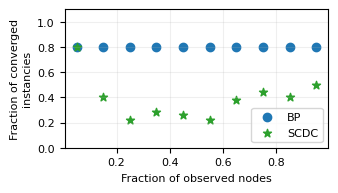

(0.0, 1.1)

In [47]:
println("Fraction of converged instancies:")
println("f_obs  : $(floor.(fracs_obs,digits=4))")
println("BP  : $(floor.(SIB_converged,digits=4))")
println("SCDC: $(floor.(SCDC_converged,digits=4))")

fig,ax = plt.subplots(figsize=(3.4,1.8))
ax.scatter(fracs_obs, SIB_converged, label="BP", c="C0", marker="o")
ax.scatter(fracs_obs, SCDC_converged, label="SCDC", c="C2", marker="*")
ax.legend()
ax.set_xlabel("Fraction of observed nodes")
ax.set_ylabel("Fraction of converged\ninstancies")
ax.grid(alpha=.2, which="both")
ax.set_ylim(0,1.1)

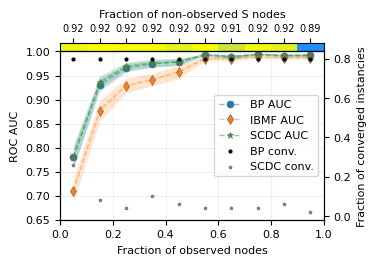

In [106]:
n_sample = 50
sims = collect(1:n_sample)

# Parameters
T = 15
NV = 300
lmax = round(sqrt(1.8/NV), digits=3)
n_sr = 2
γ = n_sr/NV
λ₀ = 0.07
fracs_obs = collect(range(.05, .95, length=10))

fig, axis = plt.subplots(2, 1, figsize=(3.4,2.3), height_ratios=(.05,.95))
ax1 = axis[2,1]
ax3 = axis[1,1]
ax2 = ax1.twinx()
rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 8  #9 18


############## SIB & IBMF ########################
sib = CSV.read("logs/test_SI/var_obs/accu_sib_all_nobs.csv", DataFrame)
ibmf = CSV.read("logs/test_SI/var_obs/accu_MF_all_nobs.csv", DataFrame)

SIB_aucs_m = zeros(length(fracs_obs))
SIB_aucs_err = zeros(length(fracs_obs))
SIB_converged = zeros(length(fracs_obs))
IBMF_aucs_m = zeros(length(fracs_obs))
IBMF_aucs_err = zeros(length(fracs_obs))

for (idx, frac_obs) in enumerate(fracs_obs)
    nobs = floor(Int, frac_obs*NV)
    
    SIB_aucs = sib[in([nobs]).(sib.nobs),"auc"]
    IBMF_aucs = ibmf[in([nobs]).(ibmf.nobs),"auc"]
    SIB_conv = sib[in([λ₀]).(sib.lamb),"sib_conv"]
    
    filter!(x->typeof(x) != Missing, SIB_aucs)
    filter!(x->typeof(x) != Missing, IBMF_aucs)
    
    SIB_aucs_m[idx] = mean(SIB_aucs)
    SIB_aucs_err[idx] = sem(SIB_aucs, mean=SIB_aucs_m[idx])
    SIB_converged[idx] = mean(SIB_conv)
    IBMF_aucs_m[idx] = mean(IBMF_aucs)
    IBMF_aucs_err[idx] = sem(IBMF_aucs, mean=IBMF_aucs_m[idx])
end
##################################################


############### SCDC #############################
SCDC_aucs_m = zeros(length(fracs_obs))
SCDC_aucs_err = zeros(length(fracs_obs))
SCDC_converged = zeros(length(fracs_obs))

lamb = zeros(length(fracs_obs)*n_sample)
seed = zeros(Int, length(fracs_obs)*n_sample)
n_obs = zeros(Int, length(fracs_obs)*n_sample) 
n_unobs = zeros(Int, length(fracs_obs)*n_sample)
n_pos = zeros(Int, length(fracs_obs)*n_sample)
auc = zeros(length(fracs_obs)*n_sample)
scdc_conv = Vector{Bool}(undef, length(fracs_obs)*n_sample)

for (idx, frac_obs) in enumerate(fracs_obs)
    nobs = floor(Int, frac_obs*NV)
    save_vec = JLD2.load_object("logs/test_SI/var_obs/data_rand_geom/N-$(NV)_lmax-$(lmax)_tlim-$(T)_nsrc-$(n_sr)_lamb-$(λ₀)/nobs_$(nobs)/optim_pars_rand_geom.jld2")
    SCDC_aucs = [save_struct.AUC for save_struct in save_vec]
    SCDC_conv = [save_struct.converged for save_struct in save_vec]
    
    lamb[(idx-1)*n_sample+1:idx*n_sample] .= λ₀
    seed[(idx-1)*n_sample+1:idx*n_sample] .= [save_struct.s for save_struct in save_vec]
    auc[(idx-1)*n_sample+1:idx*n_sample] .= SCDC_aucs
    scdc_conv[(idx-1)*n_sample+1:idx*n_sample] .= SCDC_conv
        
    filter!(x->x ≠ 0.0, SCDC_aucs)
    
    SCDC_aucs_m[idx] = mean(SCDC_aucs)
    SCDC_aucs_err[idx] = sem(SCDC_aucs, mean=SCDC_aucs_m[idx])
    SCDC_converged[idx] = mean(SCDC_conv)
end
##################################################



################## Plot AUCS  ####################
line_SIB = plot_ribbon!(ax1, fracs_obs, SIB_aucs_m, SIB_aucs_err; lab="BP AUC", mark="o", col="C0", zorder=20)
line_IBMF = plot_ribbon!(ax1, fracs_obs, IBMF_aucs_m, IBMF_aucs_err; lab="IBMF AUC", mark="d", col="C1", zorder=30)
line_SCDC = plot_ribbon!(ax1, fracs_obs, SCDC_aucs_m, SCDC_aucs_err; lab="SCDC AUC", mark="*", col="C2", zorder=40)
####################################################



############### Plot avg_S  ########################
avg_S_unobs = zeros(length(fracs_obs))

for (idx,frac_obs) in enumerate(fracs_obs)
    nobs = floor(Int, frac_obs*NV)
    avg_S = 0.0
    for s in sims
        # Load the data
        path = "data/test_SI/var_obs/data_rand_geom/N-$(NV)_lmax-$(lmax)_tlim-$(T)_nsrc-$(n_sr)_lamb-$(λ₀)/N-$(NV)_lmax-$(lmax)_tlim-$(T)_nsrc-$(n_sr)_lam-$(λ₀)_s-$(s)"
        nobs_path = "data/test_SI/var_obs/data_rand_geom/N-$(NV)_lmax-$(lmax)_tlim-$(T)_nsrc-$(n_sr)_lamb-$(λ₀)/nobs_$(nobs)/N-$(NV)_lmax-$(lmax)_tlim-$(T)_nsrc-$(n_sr)_lam-$(λ₀)_s-$(s)_obs_sparse.csv"
        confs = npzread(path*"_confs.npy")
        obs_df = CSV.read(nobs_path, DataFrame)
        obs_df.node .+= 1
        obs_df.time .+= 1

        # define unobserved nodes
        unobs_nodes = Vector(1:NV)
        filter!(e->!(e in obs_df.node), unobs_nodes)
        n_obs[(idx-1)*s+1] = length(obs_df.node)
        n_unobs[(idx-1)*s+1] = length(unobs_nodes)
        confs_unobs = Int8.(confs[1,2,unobs_nodes])
        
        n_pos[(idx-1)*s+1] = sum(confs_unobs)
        avg_S += 1 - sum(confs_unobs)/(length(unobs_nodes))
    end
    avg_S_unobs[idx] = avg_S/n_sample
end

# Custom color gradient
color1 = "dodgerblue"  # Starting color
color2 = "yellow"      # Ending color
# Create a colormap using LinearSegmentedColormap
cm = plt.matplotlib.colors.LinearSegmentedColormap.from_list("custom_cmap", [color1, color2])

avg_S_unobs = reshape(avg_S_unobs, (1,length(fracs_obs)))
pts_S = ax3.pcolormesh(avg_S_unobs,  cmap=cm)
ax3.set_xticks(.5:1:9.5)
ax3.set_xticklabels(floor.(avg_S_unobs[1,:],digits=2))
ax3.tick_params(left=false, right=false, labelleft=false, labelbottom=false, bottom=false, top=true, labeltop=true, labelsize=7)
ax3.set_xlabel("Fraction of non-observed S nodes")
ax3.xaxis.set_label_position("top")
##############################################


############ Plot average convergence ########
ax2.scatter(fracs_obs, SIB_converged, color="black", label="BP conv.", marker="o", zorder=100, s=4)
ax2.scatter(fracs_obs, SCDC_converged, color="gray", label="SCDC conv.", marker="*", zorder=100, s=4)
ax2.set_ylabel("Fraction of converged instancies")
##############################################

    
lns1, labs1 = ax1.get_legend_handles_labels() 
lns2, labs2 = ax2.get_legend_handles_labels() 
ax1.legend(vcat(lns1,lns2), vcat(labs1,labs2), loc="center right")
ax1.grid(alpha=.2, which="both")
ax1.set_ylim(0.65,1)
ax1.set_yticks(0.65:.05:1)
ax1.set_xticks(0:.2:1)
ax1.set_xlabel("Fraction of observed nodes")
ax1.set_ylabel("ROC AUC")
ax2.set_zorder(ax1.get_zorder()+1)
ax1.patch.set_visible(false)
plt.subplots_adjust(wspace=0, hspace=0)
#fig.savefig("AUC_var_obs_ribbon.pdf", bbox_inches="tight")